In [1]:
import vishack
import matplotlib.pyplot as plt
import numpy as np
import control
import kontrol

data1 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241101.xml")
data2 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241103.xml")
data3 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241115.xml")
data4 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241120.xml")
data5 = vishack.data.diaggui.Diaggui("../data/all_sensors_20241203.xml")

ModuleNotFoundError: No module named 'vishack'

In [215]:
data_list = [data1, data2, data3, data4, data5]
inert_list = []
inert_res_list = []
cps_list = []
cps_res_list = []
log_inert_list = []
log_t240_list = []

s = control.tf("s")
seis_cal = 1/s*1e-9
wn = 1*2*np.pi
q = 1/np.sqrt(2)
inert_cal = (s**2 + wn/q*s + wn**2) / s**3 * 1e-9

for data in data_list:
    f, inert = data.psd("L1:ISI-HAM8_BLND_GS13Y_IN1_DQ")
    f, cps = data.psd("L1:ISI-HAM8_BLND_CPSY_IN1_DQ")
    f, coh = data.coh("L1:ISI-HAM8_BLND_GS13Y_IN1_DQ", "L1:ISI-GND_STS_HAM8_Y_DQ")
    f, cps_coh = data.coh("L1:ISI-HAM8_BLND_CPSY_IN1_DQ", "L1:ISI-HAM8_BLND_T240Y_IN1_DQ")
    f, t240 = data.psd("L1:ISI-HAM8_BLND_T240Y_IN1_DQ")
    
    inert = inert[f>0]
    coh = coh[f>0]
    t240 = t240[f>0]
    cps_coh = cps_coh[f>0]
    inert = inert * abs(inert_cal(1j*2*np.pi*f))
    cps = cps * 1e-9
    t240 = t240 * abs(seis_cal(1j*2*np.pi*f))
    inert_res = (inert**2 * (1-coh**.5))**.5
    cps_res = (cps**2 * (1-cps_coh**.5))**.5
    

    inert_list.append(inert)
    cps_list.append(cps)
    log_inert_list.append(np.log10(inert_res))
    inert_res_list.append(inert_res)
    cps_res_list.append(cps_res)
    log_t240_list.append(np.log10(t240))
    # log_res_list.append(np.log10(res))

inert_mean = 10**np.mean(log_inert_list, axis=0)
inert_std = np.std(log_inert_list, axis=0)
inert_sigma1 = 10**(np.log10(inert_mean) + inert_std)
inert_sigma2 = 10**(np.log10(inert_mean) + 3*inert_std)

t240_mean = 10**np.mean(log_t240_list, axis=0)
# seis_mean = 10**np.mean(log_seis_list, axis=0)
# seis_std = np.std(log_seis_list, axis=0)
# seis_sigma1 = 10**(np.log10(seis_mean) + seis_std)
# seis_sigma2 = 10**(np.log10(seis_mean) + 2*seis_std)

# res_mean = 10**np.mean(log_res_list, axis=0)
# res_std = np.std(log_res_list, axis=0)
# res_sigma1 = 10**(np.log10(res_mean) + res_std)
# res_sigma2 = 10**(np.log10(res_mean) + 2*res_std)

# f = f[f>0]

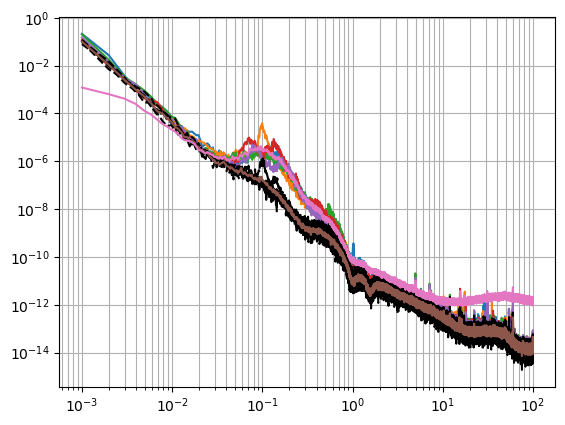

In [217]:
for inert in inert_list:
    plt.loglog(f, inert)

# for cps in cps_list:
#     plt.loglog(f, cps)

# for cps in cps_res_list:
#     plt.loglog(f, cps)

# plt.loglog(f, n_cps, "k")
for inert_res in inert_res_list:
    plt.loglog(f, inert_res, "k--")

plt.loglog(f, inert_mean)
# plt.loglog(f, inert_sigma1)
# plt.loglog(f, inert_sigma2)

plt.loglog(f, t240_mean)

plt.grid(which="both")

In [60]:
# Get corrected CPS noise
seis_data = np.load("noise_spectrums/seismic_mean.npz")
seismometer_data = np.load("noise_spectrums/seismometer_mean.npz")
seis = seis_data["data"]
seismometer = seismometer_data["data"]

h_sc_mean = kontrol.load_transfer_function("sensor_correction_filters/h_sc_mean.pkl")
h_sc_prefilt = kontrol.load_transfer_function("sensor_correction_filters/prefilt.pkl")

h_sc_mean *= h_sc_prefilt

seis_filt = seis*abs(1-h_sc_mean(1j*2*np.pi*f))
seismometer_filt = seismometer * abs(h_sc_mean(1j*2*np.pi*f))
n_sc_mean = (seis_filt**2 + seismometer_filt**2)**.5
cps_mean = (n_cps**2 + n_sc_mean**2)**.5
# h_sc_sigma1


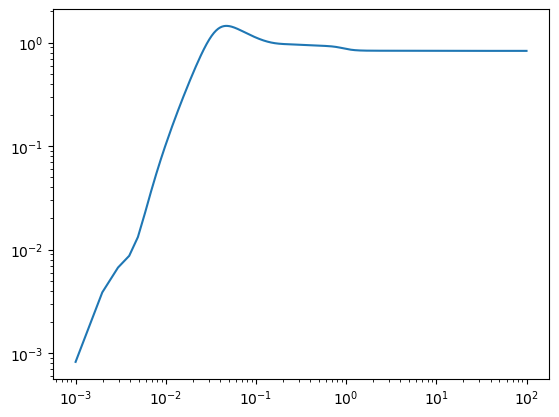

In [61]:
plt.loglog(f, abs(h_sc_mean(1j*2*np.pi*f)))

In [181]:
import scipy

inert_interp = scipy.interpolate.interp1d(f, np.log10(inert_mean))
inert_sigma1_interp = scipy.interpolate.interp1d(f, np.log10(inert_sigma1))
inert_sigma2_interp = scipy.interpolate.interp1d(f, np.log10(inert_sigma2))
cps_interp = scipy.interpolate.interp1d(f, np.log10(cps_mean))

In [78]:
f_ = np.logspace(-3, 2, 1024)

In [81]:
inert_interp(f_)

array([ -0.9985974 ,  -1.00981309,  -1.02115573, ..., -13.93203712,
       -13.75630339, -13.41318741])

In [182]:
inert_data = 10**inert_interp(f_)
inert_sigma1_data = 10**inert_sigma1_interp(f_)
inert_sigma2_data = 10**inert_sigma2_interp(f_)
cps_data = 10**cps_interp(f_)

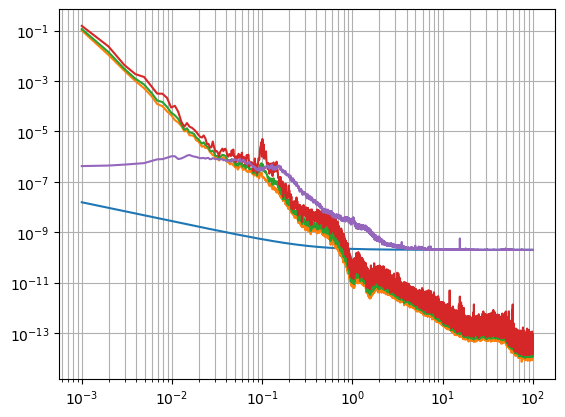

In [259]:
# plt.loglog(f, seismometer_filt)
# plt.loglog(f, seis_filt)
plt.loglog(f, n_cps)
plt.loglog(f, inert_mean)
plt.loglog(f, inert_sigma1)
plt.loglog(f, inert_sigma2)
# plt.loglog(f_, inert_data*abs(h2p(1j*2*np.pi*f_)))
# plt.loglog(f_, inert_pad)
# plt.loglog(f_, abs(inert_fit(1j*2*np.pi*f_)))
plt.loglog(f, cps_mean)
# plt.loglog(f_, cps_data*abs(h1p(1j*2*np.pi*f_)))
# plt.loglog(f_, abs(cps_fit(1j*2*np.pi*f_)))

# plt.loglog(f, inert_sigma1)
# plt.loglog(f_, inert_sigma1_data)
# plt.loglog(f_, abs(inert_sigma1_fit(1j*2*np.pi*f_)))

# plt.loglog(f_, inert_sigma2_data)
# plt.loglog(f_, abs(inert_sigma2_fit(1j*2*np.pi*f_)))

# plt.loglog(f, inert_sigma2)
plt.grid(which="both")

In [205]:
inert_pad = inert_data.copy()
inert_pad[f_<0.003] = inert_data[f_>0.003][0]
inert_pad[f_>20] = inert_data[f_<20][-1]

inert_sigma1_pad = inert_sigma1_data.copy()
inert_sigma1_pad[f_<0.003] = inert_sigma1_data[f_>0.003][0]
inert_sigma1_pad[f_>20] = inert_sigma1_data[f_<20][-1]

inert_sigma2_pad = inert_sigma2_data.copy()
inert_sigma2_pad[f_<0.003] = inert_sigma2_data[f_>0.003][0]
inert_sigma2_pad[f_>20] = inert_sigma2_data[f_<20][-1]

inert_mask = (f_<0.3) + (f_>2)
sigma2_mask = (f_<0.08) + (f_>0.14)

In [107]:
inert_fit = kontrol.curvefit.spectrum_fit(f=f_[inert_mask], spectrum=inert_pad[inert_mask], nzero=8, npole=8)

In [145]:
inert_sigma1_fit = kontrol.curvefit.spectrum_fit(f=f_[inert_mask], spectrum=inert_sigma1_pad[inert_mask], nzero=8, npole=8)

In [206]:
inert_sigma2_fit = kontrol.curvefit.spectrum_fit(f=f_[inert_mask*sigma2_mask], spectrum=inert_sigma2_pad[inert_mask*sigma2_mask], nzero=8, npole=8)

In [109]:
cps_fit = kontrol.curvefit.spectrum_fit(f=f_, spectrum=cps_data, nzero=6, npole=6)

In [287]:
f_ = np.logspace(-4, 2, 1024)

In [26]:
def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]
n_cps = noise_model(f, *n_ade1_params)

In [233]:
tf_weight = kontrol.load_transfer_function("suspension_models/hsts_weight.pkl")
s = control.tf("s")
weight = (s+(2*np.pi*10))/(s+(2*np.pi*1)) / 10

In [244]:
comp = kontrol.ComplementaryFilter()
comp.noise1 = cps_fit * tf_weight
comp.noise2 = inert_fit * tf_weight * weight
comp.weight1 = 1/inert_fit / weight
comp.weight2 = 1/cps_fit
h1, h2 = comp.h2synthesis()
h1, h2 = comp.hinfsynthesis()

In [240]:
comp_sigma1 = kontrol.ComplementaryFilter()
comp_sigma1.noise1 = cps_fit * tf_weight
comp_sigma1.noise2 = inert_sigma1_fit * tf_weight * weight
comp_sigma1.weight1 = 1/inert_sigma1_fit / weight
comp_sigma1.weight2 = 1/cps_fit
h1_sigma1, h2_sigma1 = comp_sigma1.h2synthesis()
h1_sigma1, h2_sigma1 = comp_sigma1.hinfsynthesis()

In [241]:
comp_sigma2 = kontrol.ComplementaryFilter()
comp_sigma2.noise2 = cps_fit * tf_weight
comp_sigma2.noise1 = inert_sigma2_fit * tf_weight * weight
comp_sigma2.weight2 = 1/inert_sigma2_fit / weight
comp_sigma2.weight1 = 1/cps_fit
h1_sigma2, h2_sigma2 = comp_sigma2.h2synthesis()
h2_sigma2, h1_sigma2 = comp_sigma2.hinfsynthesis()

In [245]:
prefilt = (s/(s+2*np.pi*0.003))**4
h2p = h2*prefilt
h1p = 1-h2p

h2p_sigma1 = h2_sigma1*prefilt
h1p_sigma1 = 1-h2p_sigma1

h2p_sigma2 = h2_sigma2*prefilt
h1p_sigma2 = 1-h2p_sigma2

In [226]:
ligo_h1 = kontrol.load_transfer_function("complementary_filters/102mHzv2_disp.pkl")
ligo_h2 = kontrol.load_transfer_function("complementary_filters/102mHzv2_inert.pkl")

ligo_h2 /= (s**2 + wn/q*s + wn**2) / s**3

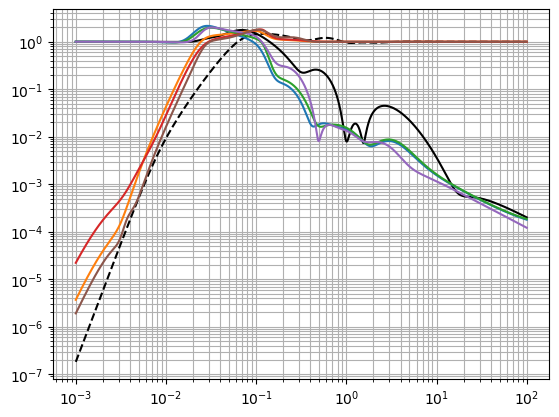

In [267]:
# plt.loglog(f_, abs(h1(1j*2*np.pi*f_)))
# plt.loglog(f_, abs(h2(1j*2*np.pi*f_)))
plt.loglog(f_, abs(ligo_h1(1j*2*np.pi*f_)), "k")
plt.loglog(f_, abs(ligo_h2(1j*2*np.pi*f_)), "k--")

plt.loglog(f, abs(h1p(1j*2*np.pi*f)))
plt.loglog(f_, abs(h2p(1j*2*np.pi*f_)))

plt.loglog(f_, abs(h1p_sigma1(1j*2*np.pi*f_)))
plt.loglog(f_, abs(h2p_sigma1(1j*2*np.pi*f_)))

plt.loglog(f_, abs(h1p_sigma2(1j*2*np.pi*f_)))
plt.loglog(f_, abs(h2p_sigma2(1j*2*np.pi*f_)))

plt.grid(which="both")

In [266]:
h1p

TransferFunction(array([2.13983891e+00, 1.87846421e+03, 2.10735338e+05, 1.23301955e+07,
       4.36747542e+08, 1.09708016e+10, 2.03616538e+11, 3.02215427e+12,
       3.60631900e+13, 3.56544969e+14, 2.93689272e+15, 2.02015656e+16,
       1.17108776e+17, 5.74044132e+17, 2.39194787e+18, 8.47593227e+18,
       2.54979194e+19, 6.49959196e+19, 1.39793806e+20, 2.52305570e+20,
       3.79583811e+20, 4.73431207e+20, 4.87983991e+20, 4.13702776e+20,
       2.86036545e+20, 1.59591455e+20, 7.08084374e+19, 2.45170709e+19,
       6.53827624e+18, 1.34179829e+18, 2.12638299e+17, 2.60437012e+16,
       2.45630945e+15, 1.76282023e+14, 9.39318364e+12, 3.58228744e+11,
       9.36474654e+09, 1.60439531e+08, 1.70213708e+06, 1.02042515e+04,
       2.92687318e+01, 3.09639704e-02]), array([1.00000000e+00, 1.87846203e+04, 1.98123418e+06, 1.08077880e+08,
       3.83246477e+09, 9.74681356e+10, 1.87254854e+12, 2.81846188e+13,
       3.42150922e+14, 3.41238215e+15, 2.81842837e+16, 1.93540568e+17,
       1.11054725e+

In [269]:
#export

h1p = kontrol.TransferFunction(h1p)
h1p.save("complementary_filters/h1_mean.pkl")

h2 = kontrol.TransferFunction(h2)
h2.save("complementary_filters/h2_mean.pkl")

h1p_sigma1 = kontrol.TransferFunction(h1p_sigma1)
h1p_sigma1.save("complementary_filters/h1_sigma1.pkl")

h2_sigma1 = kontrol.TransferFunction(h2_sigma1)
h2_sigma1.save("complementary_filters/h2_sigma1.pkl")

h1p_sigma2 = kontrol.TransferFunction(h1p_sigma2)
h1p_sigma2.save("complementary_filters/h1_sigma2.pkl")

h2_sigma2 = kontrol.TransferFunction(h2_sigma2)
h2_sigma2.save("complementary_filters/h2_sigma2.pkl")

h2_prefilt = kontrol.TransferFunction(prefilt)
h2_prefilt.save("complementary_filters/h2_prefilt.pkl")

In [260]:
#export noise spectrums
np.savez("noise_spectrums/inert_mean.npz", f=f, data=inert_mean)
np.savez("noise_spectrums/inert_sigma1.npz", f=f, data=inert_sigma1)
np.savez("noise_spectrums/inert_sigma2.npz", f=f, data=inert_sigma2)

np.savez("noise_spectrums/cps.npz", f=f, data=n_cps)